In [17]:
# ============================= Step 1: Import Libraries ============================= #
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelBinarizer

In [23]:
# ============================= Step 2: Load and Inspect Dataset ============================= #
df = pd.read_csv("data/normalized-data-crop-recommendation.csv")

print("First 5 rows of the dataset:")
print(df.head())
print("Column names in dataset:", df.columns)

First 5 rows of the dataset:
   Nitrogen Content  Phosphorous Content  Potassium Content  temperature  \
0          0.642857             0.264286           0.147368     0.363919   
1          0.607143             0.378571           0.136842     0.390810   
2          0.428571             0.357143           0.152632     0.428065   
3          0.528571             0.214286           0.131579     0.533328   
4          0.557143             0.264286           0.142105     0.341289   

   humidity        ph  rainfall label  
0  0.831411  0.501001  0.656458  rice  
1  0.809515  0.680005  0.741675  rice  
2  0.835548  0.948326  0.875710  rice  
3  0.807417  0.660705  0.799905  rice  
4  0.826235  0.877497  0.871231  rice  
Column names in dataset: Index(['Nitrogen Content', 'Phosphorous Content', 'Potassium Content',
       'temperature', 'humidity', 'ph', 'rainfall', 'label'],
      dtype='object')


In [21]:
# ============================= Step 3: Split Dataset (90-10, then 80-20) ============================= #
X = df.drop(columns=["label"])  # Features
y = df["label"]  # Target

# Split into 90% training/testing and 10% unseen data
X_train_test, X_unseen, y_train_test, y_unseen = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)

# Further split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.20, random_state=42, stratify=y_train_test)

print("Dataset Split Summary:")
print(f"Training Data: {X_train.shape[0]} rows")
print(f"Testing Data: {X_test.shape[0]} rows")
print(f"Unseen Data: {X_unseen.shape[0]} rows")

Dataset Split Summary:
Training Data: 720 rows
Testing Data: 180 rows
Unseen Data: 100 rows


In [26]:
# ============================= Step 4: Implement Rule-Based Classification ============================= #
def rule_based_classifier(row):
    """Rule-Based Classifier for selected crops."""
    
    if row["humidity"] > 0.75 and 0.4 <= row["Nitrogen Content"] <= 0.6 and 0.5 <= row["rainfall"] <= 0.7:
        return "rice"
    
    elif row["humidity"] > 0.7 and 0.4 <= row["Nitrogen Content"] <= 0.6 and row["rainfall"] > 0.7:
        return "jute"
    
    elif 0.4 <= row["Nitrogen Content"] <= 0.6 and 0.3 <= row["Phosphorous Content"] <= 0.5 and 0.3 <= row["Potassium Content"] <= 0.5:
        return "maize"

    elif row["Nitrogen Content"] > 0.6 and row["Phosphorous Content"] < 0.3 and 6.0 <= row["ph"] <= 7.0:
        return "kidneybeans"
    
    elif row["Nitrogen Content"] < 0.4 and 0.3 <= row["Phosphorous Content"] <= 0.6 and 6.0 <= row["ph"] <= 7.5:
        return "lentil"

    elif row["humidity"] < 0.5 and row["temperature"] > 0.7 and 6.5 <= row["ph"] <= 7.5:
        return "grapes"
    
    elif row["temperature"] > 0.7 and row["Phosphorous Content"] >= 0.4 and row["rainfall"] > 0.7:
        return "watermelon"

    elif row["temperature"] > 0.7 and row["Phosphorous Content"] < 0.3 and 0.3 <= row["Potassium Content"] <= 0.6:
        return "muskmelon"
    
    elif row["temperature"] > 0.7 and row["humidity"] < 0.5 and row["Potassium Content"] > 0.6:
        return "cotton"
    
    elif 0.4 <= row["temperature"] <= 0.6 and 0.4 <= row["humidity"] <= 0.6 and 5.5 <= row["ph"] <= 6.5:
        return "coffee"
    
    else:
        return "unknown"

# Apply rule-based classification
df["Predicted_Label"] = df.apply(rule_based_classifier, axis=1)
print("Unknown classifications:", df[df["Predicted_Label"] == "unknown"].shape[0])
print(df[["label", "Predicted_Label"]].head())

Unknown classifications: 900
  label Predicted_Label
0  rice         unknown
1  rice         unknown
2  rice            jute
3  rice            jute
4  rice            jute


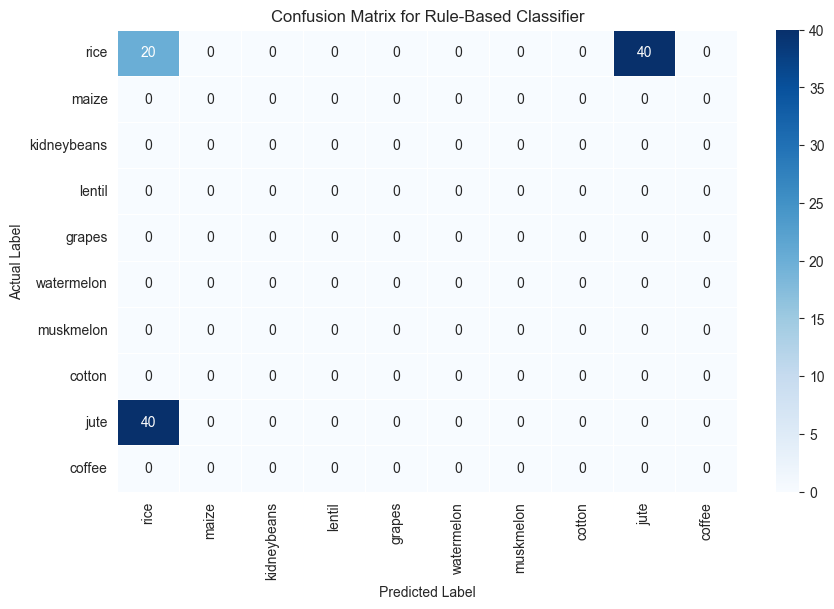

Model Performance Metrics:
Accuracy: 0.02
Precision: 0.8333333333333334
Recall: 0.02
ROC-AUC Score: 0.5055555555555555


In [28]:
# ============================= Step 5: Model Performance ============================= #
y_true = df["label"]
y_pred = df["Predicted_Label"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=df["label"].unique())
cm_df = pd.DataFrame(cm, index=df["label"].unique(), columns=df["label"].unique())

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Rule-Based Classifier")
plt.show()

# Evaluation metrics
print("Model Performance Metrics:")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="weighted", zero_division=1))
print("Recall:", recall_score(y_true, y_pred, average="weighted", zero_division=1))

#ROC-AUC Score
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)
y_pred_bin = lb.transform(y_pred)

roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average="weighted", multi_class="ovr")
print("ROC-AUC Score:", roc_auc)

In [29]:
# =============================  Step 6: 10-Fold Cross-Validation ============================= #
class RuleBasedClassifier(BaseEstimator, ClassifierMixin):
    """Custom Rule-Based Classifier compatible with scikit-learn"""
    
    def fit(self, X, y):
        return self  # Dummy fit method
    
    def predict(self, X):
        return np.array([rule_based_classifier(row) for _, row in X.iterrows()])

# Rule-Based Classifier object
rule_clf = RuleBasedClassifier()

# 10-Fold Cross-Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rule_clf, X_train, y_train, cv=kf, scoring="accuracy")

print("10-Fold Cross-Validation Accuracy:", cv_scores.mean())


10-Fold Cross-Validation Accuracy: 0.016666666666666666


C:\Users\moann\AppData\Local\Temp\ipykernel_21176\3648629241.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(x=df["label"], order=df["label"].value_counts().index, palette="viridis")
C:\Users\moann\AppData\Local\Temp\ipykernel_21176\3648629241.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(x=df["Predicted_Label"], order=df["Predicted_Label"].value_counts().index, palette="coolwarm")
C:\Users\moann\AppData\Local\Temp\ipykernel_21176\3648629241.py:25: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\moann\AppData\Local\Temp\ipykernel_21176\3648629241.py:25: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s

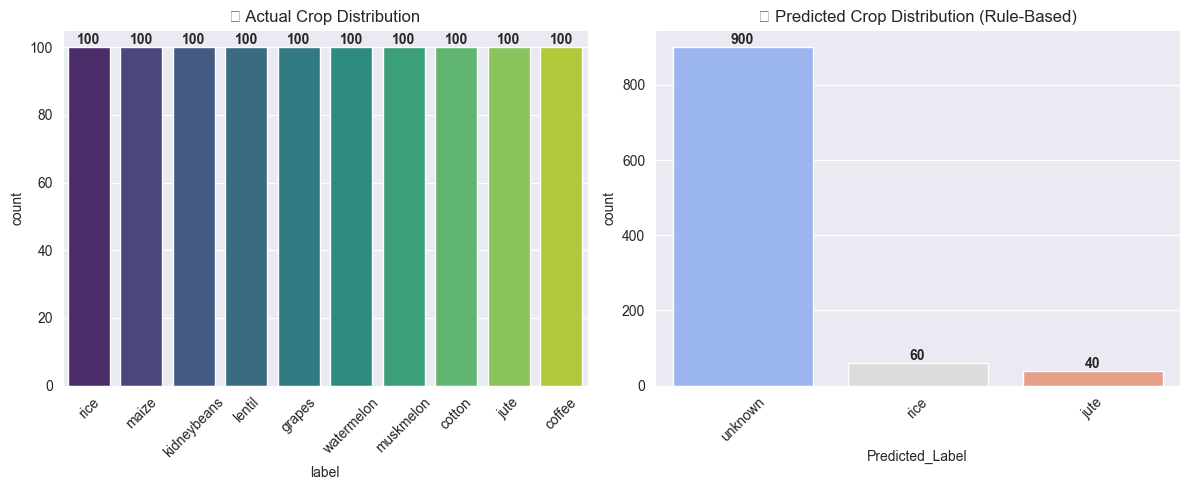

In [30]:
# ============================= Step 7: Crop Distribution Visualization ============================= #
def add_value_labels(ax):
    """Add exact value labels to bar charts"""
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.figure(figsize=(12, 5))

# Actual crop distribution
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x=df["label"], order=df["label"].value_counts().index, palette="viridis")
plt.title("🌱 Actual Crop Distribution")
plt.xticks(rotation=45)
add_value_labels(ax1)

# Predicted crop distribution
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x=df["Predicted_Label"], order=df["Predicted_Label"].value_counts().index, palette="coolwarm")
plt.title("📌 Predicted Crop Distribution (Rule-Based)")
plt.xticks(rotation=45)
add_value_labels(ax2)

plt.tight_layout()
plt.show()